## A script to build the model and train the chatbot

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

In [16]:
lemmatizer = WordNetLemmatizer()
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [17]:
intents['intents'][0]

{'tag': 'greeting',
 'patterns': ['Hi there',
  'How are you',
  'Is anyone there?',
  'Hey',
  'Hola',
  'Hello',
  'Good day'],
 'responses': ['Hello, thanks for asking',
  'Good to see you again',
  'Hi there, how can I help?'],
 'context': ['']}

In [20]:
# nltk.download('punkt')
for intent in intents['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)          #tokenize each word
        words.extend(w)                          #add documents in the corpus
        documents.append((w, intent['tag']))
        
        if intent['tag'] not in classes:         # add to our classes list
            classes.append(intent['tag'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [23]:
# classes
documents[:5]

[(['Hi', 'there'], 'greeting'),
 (['How', 'are', 'you'], 'greeting'),
 (['Is', 'anyone', 'there', '?'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Hola'], 'greeting')]

In [34]:
sorted(words)[:10]

["'s",
 ',',
 'a',
 'adverse',
 'all',
 'anyone',
 'are',
 'awesome',
 'be',
 'behavior']

In [33]:
# lemmaztize and lower each word and remove duplicates
# nltk.download('wordnet')
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
words[:10]

["'s",
 ',',
 'a',
 'adverse',
 'all',
 'anyone',
 'are',
 'awesome',
 'be',
 'behavior']

In [36]:
# sort classes
classes = sorted(list(set(classes)))
classes

['adverse_drug',
 'blood_pressure',
 'blood_pressure_search',
 'goodbye',
 'greeting',
 'hospital_search',
 'options',
 'pharmacy_search',
 'thanks']

In [37]:
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

47 documents
9 classes ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
88 unique lemmatized words ["'s", ',', 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


In [38]:
# creating the pickle files for the words and the classes
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

### Creating the training data

In [41]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

In [42]:
# shuffle our features and turn into np.array
random.shuffle(training)

In [43]:
training = np.array(training)

In [106]:
train_x = list(training[:,0])
train_y = list(training[:,1])

### Build the model

In [107]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

In [108]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch /20))

In [109]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [110]:
# history = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=5, verbose=1, callbacks=[lr_schedule])
history = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=5, verbose=1)

Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 2.2066 - accuracy: 0.1064
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 2.1553 - accuracy: 0.1489
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 2.0207 - accuracy: 0.2766
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 2.0206 - accuracy: 0.2979
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 1.8141 - accuracy: 0.4468
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 1.7911 - accuracy: 0.3830
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 1.6557 - accuracy: 0.4255
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 1.5376 - accuracy: 0.5319
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 1.4002 - accuracy: 0.6383
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 1.2664 - accuracy: 0.6596
Epoch 11/

10/10 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 1.0000: 0s - loss: 0.0208 - accuracy: 1.00
Epoch 82/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9787
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.9787
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0238 - accuracy: 1.0000
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0305 - accuracy: 1.0000
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0412 - accuracy: 1.0000
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9787
Epoch 88/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 1.0000
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0590 - accuracy: 0.9787
Epoch 90/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0

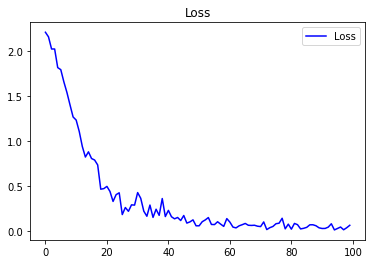

<Figure size 432x288 with 0 Axes>

In [112]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [111]:
model.save('chatbot_model.h5', hist)